In [1]:
import pandas as pd

unemployment = pd.read_csv('Unemployment.csv')
leases = pd.read_csv('Leases.csv')
price_availability = pd.read_csv('Price and Availability Data.csv')
occupancy = pd.read_csv('Major Market Occupancy Data-revised.csv')


               market        market_std       date
12   Dallas-Ft. Worth  Dallas/Ft. Worth 2018-01-01
58      Washington DC   Washington D.C. 2018-01-01
72   Dallas-Ft. Worth  Dallas/Ft. Worth 2018-04-01
118     Washington DC   Washington D.C. 2018-04-01
132  Dallas-Ft. Worth  Dallas/Ft. Worth 2018-07-01
market_std                          0
region                              0
CBD_suburban                        0
date                                0
leasedSF                            0
availability_proportion_weighted    0
dtype: int64


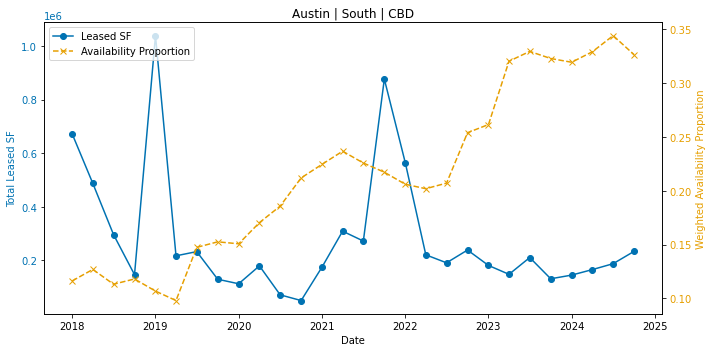

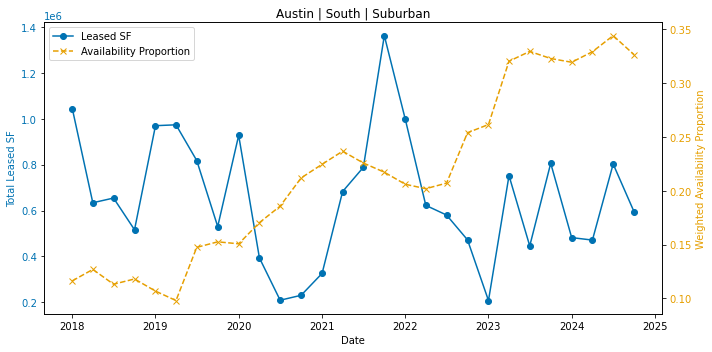

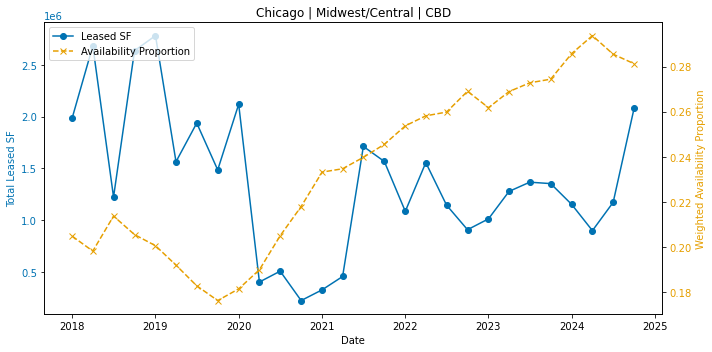

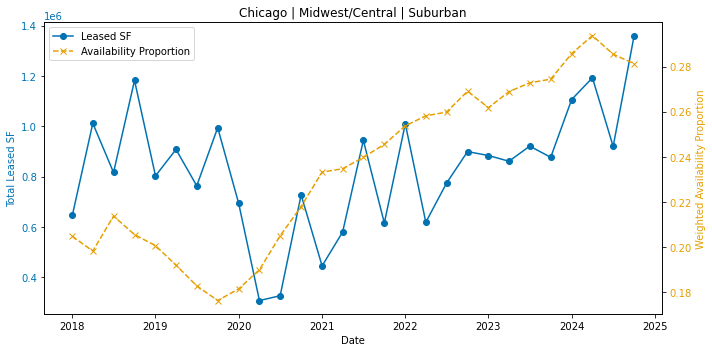

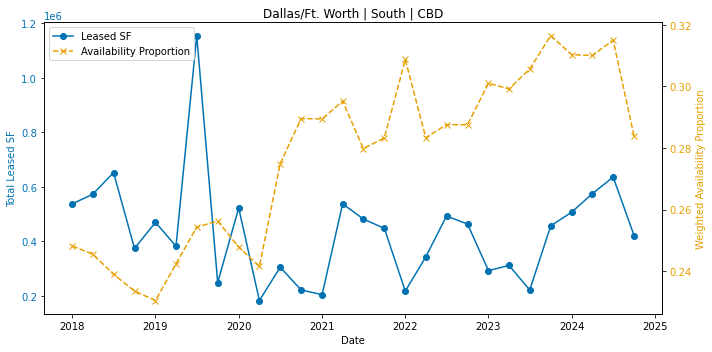

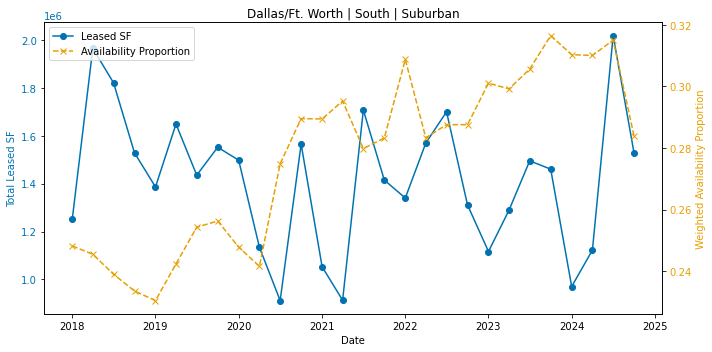

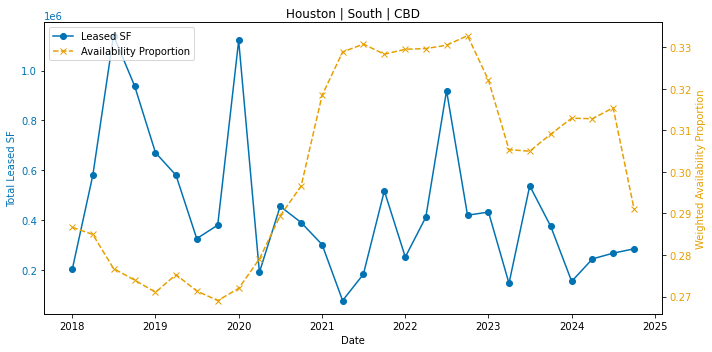

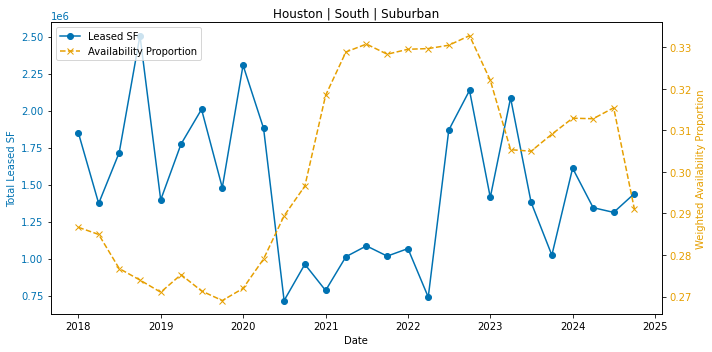

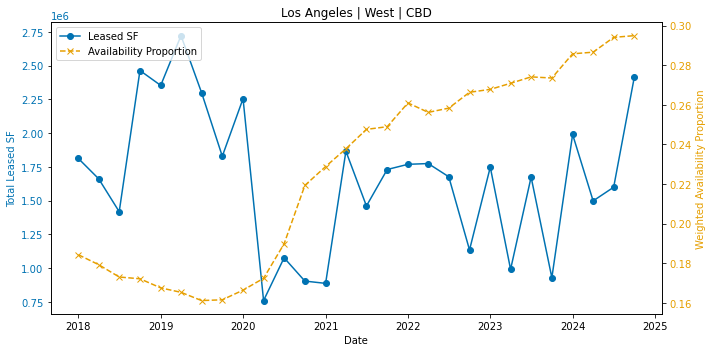

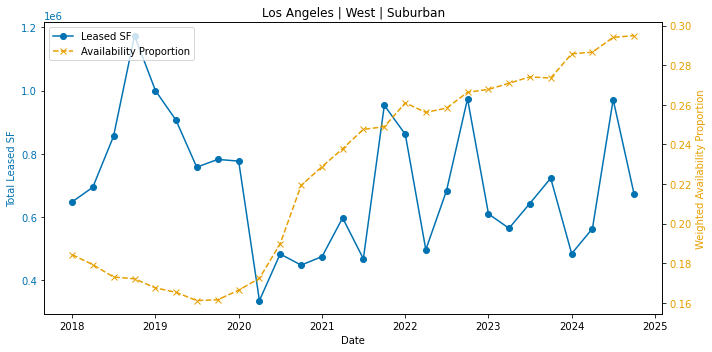

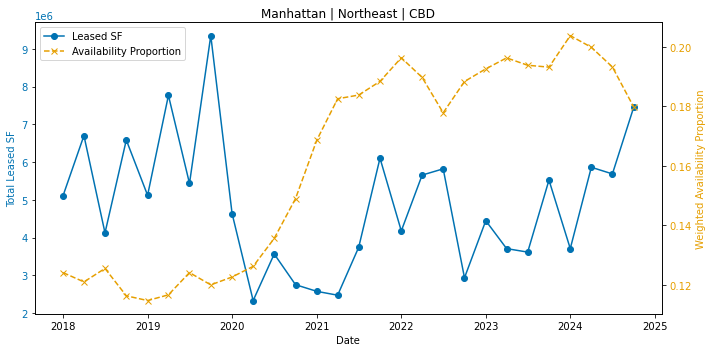

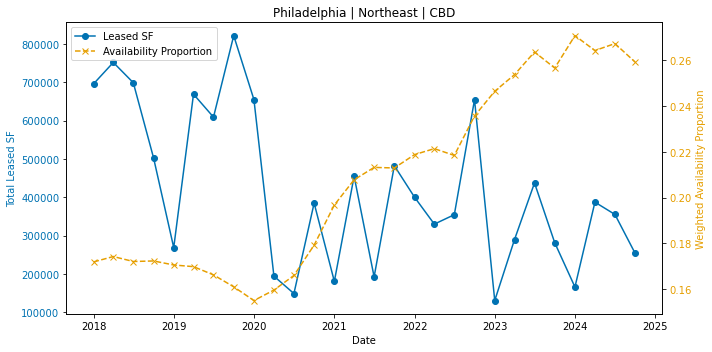

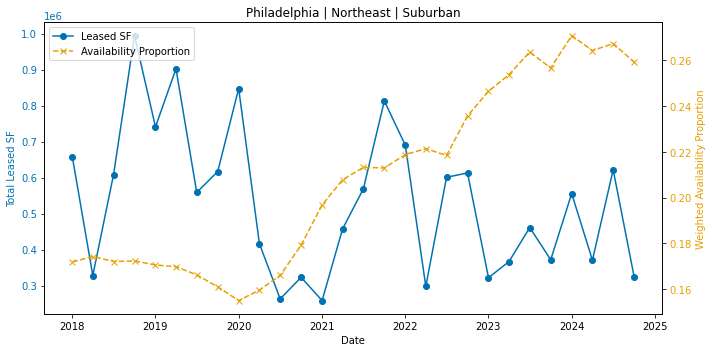

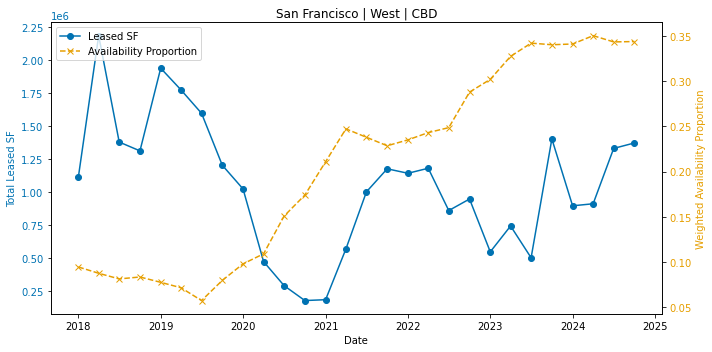

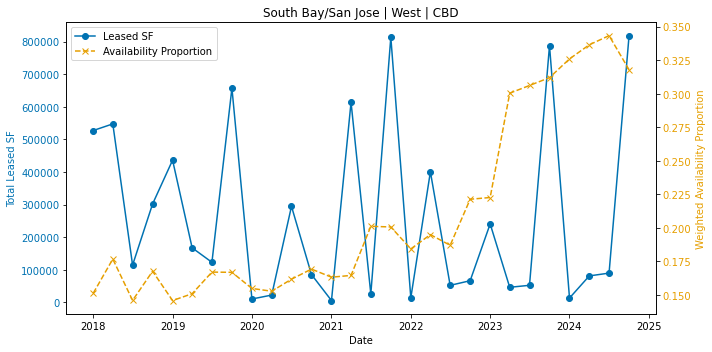

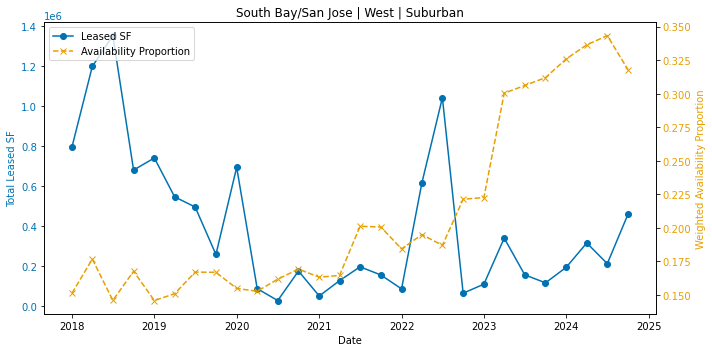

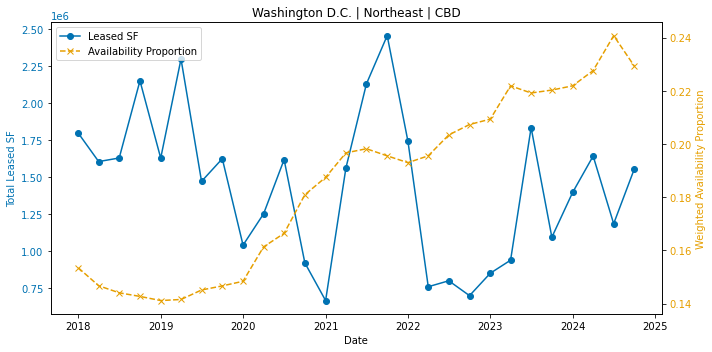

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the Leases dataset and clean up any leading/trailing spaces in column names
df_leases = pd.read_csv('Leases.csv')
df_leases.columns = df_leases.columns.str.strip()

# Define a mapping to standardize market names across datasets
# This ensures we can compare markets consistently
map_leases = {
    'Austin': 'Austin',
    'Chicago': 'Chicago',
    'Chicago Suburbs': 'Chicago',
    'Dallas/Ft Worth': 'Dallas/Ft. Worth',            # noticed missing dash and space 
    'Houston': 'Houston',
    'Los Angeles': 'Los Angeles',
    'Manhattan': 'Manhattan',
    'Philadelphia': 'Philadelphia',
    'San Francisco': 'San Francisco',
    'South Bay/San Jose': 'South Bay/San Jose',
    'Washington D.C.': 'Washington D.C.'
}

# Apply the standard naming to the 'market' column
df_leases['market_std'] = df_leases['market'].map(map_leases)

# Only keep Class A buildings for analysis
df_leases = df_leases[df_leases['internal_class'] == 'A'].copy()

# Convert 'quarter' info into a representative month for datetime conversion
def quarter_to_month(q):
    return {1: 1, 2: 4, 3: 7, 4: 10}.get(q, 1)

# Ensure quarter is numeric and create a new datetime column
if df_leases['quarter'].dtype == 'O':
    df_leases['quarter'] = df_leases['quarter'].str.replace('Q', '', regex=False).astype(int)

df_leases['month'] = df_leases['quarter'].apply(quarter_to_month)
df_leases['date'] = pd.to_datetime(df_leases['year'].astype(str) + '-' +
                                   df_leases['month'].astype(str) + '-01')

# Group the lease data by market/date/region/type and sum leased square footage
grouped_leases = df_leases.groupby(['market_std', 'region', 'CBD_suburban', 'date']).agg({
    'leasedSF': 'sum'  # total leasing volume
}).reset_index()


# Load Price & Availability dataset and clean column names
df_pa = pd.read_csv('Price and Availability Data.csv')
df_pa.columns = df_pa.columns.str.strip()

# Standardize market names (same logic as above)
map_pa = {
    'Austin': 'Austin',
    'Chicago Suburbs': 'Chicago',
    'Downtown Chicago': 'Chicago',
    'Dallas-Ft. Worth': 'Dallas/Ft. Worth',            # noticed missing dash or space
    'Houston': 'Houston',
    'Los Angeles': 'Los Angeles',
    'Manhattan': 'Manhattan',
    'Philadelphia': 'Philadelphia',
    'San Francisco': 'San Francisco',
    'South Bay': 'South Bay/San Jose',                 # noticed naming inconsistency
    'Washington DC': 'Washington D.C.'                 # noticed missing period
}

# Apply standard market naming
df_pa['market_std'] = df_pa['market'].map(map_pa)

# Clean quarter and convert to representative month
df_pa['quarter'] = df_pa['quarter'].astype(str).str.replace('Q', '', regex=False).astype(int)
df_pa['month'] = df_pa['quarter'].apply(quarter_to_month)

# Create date column for merging
df_pa['date'] = pd.to_datetime(df_pa['year'].astype(str) + '-' + df_pa['month'].astype(str) + '-01')

# Check the fix worked — confirm valid entries now exist
print(df_pa[df_pa['market_std'].isin(['Dallas/Ft. Worth', 'Washington D.C.'])][['market', 'market_std', 'date']].drop_duplicates().head())

# Filter for Class A properties only
df_pa = df_pa[df_pa['internal_class'] == 'A'].copy()

# Recompute date (in case filtering changed it)
df_pa['month'] = df_pa['quarter'].apply(quarter_to_month)
df_pa['date'] = pd.to_datetime(df_pa['year'].astype(str) + '-' +
                               df_pa['month'].astype(str) + '-01')

# Compute weighted availability: available space as % of total rentable space (RBA)
grouped_pa = df_pa.groupby(['market_std', 'date']).agg({
    'available_space': 'sum',
    'RBA': 'sum'
}).reset_index()

grouped_pa['availability_proportion_weighted'] = grouped_pa['available_space'] / grouped_pa['RBA']


# Merge lease activity with availability for direct comparison
merged = pd.merge(
    grouped_leases,
    grouped_pa[['market_std', 'date', 'availability_proportion_weighted']],
    on=['market_std', 'date'],
    how='left'
)

# Confirm that no missing values exist for these key markets post-fix
print(merged[merged['market_std'].isin(['Dallas/Ft. Worth', 'Washington D.C.'])].isna().sum())


# ===== Step 4: Filter to Major Markets =====

# Focus only on the top 10 metro markets of interest
major_markets = [
    'Austin', 'Chicago', 'Dallas/Ft. Worth', 'Houston', 'Los Angeles',
    'Manhattan', 'Philadelphia', 'San Francisco', 'South Bay/San Jose', 'Washington D.C.'
]

merged = merged[merged['market_std'].isin(major_markets)]


# ===== Step 5: Create Dual-Axis Charts per Market/Region/Submarket Type =====

# Generate one chart per market-region-CBD/suburban split
for key, group in merged.groupby(['market_std', 'region', 'CBD_suburban']):
    fig, ax1 = plt.subplots(figsize=(10, 5))

    # Plot leased SF (demand side)
    p1 = ax1.plot(group['date'], group['leasedSF'], label='Leased SF',
                  color='#0072B2', marker='o', linestyle='-')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Total Leased SF', color='#0072B2')
    ax1.tick_params(axis='y', labelcolor='#0072B2')

    # Plot availability proportion (supply side)
    ax2 = ax1.twinx()
    p2 = ax2.plot(group['date'], group['availability_proportion_weighted'], label='Availability Proportion',
                  color='#E69F00', marker='x', linestyle='--')
    ax2.set_ylabel('Weighted Availability Proportion', color='#E69F00')
    ax2.tick_params(axis='y', labelcolor='#E69F00')

    # Combine legends and show chart
    lines = p1 + p2
    labels = [line.get_label() for line in lines]
    ax1.legend(lines, labels, loc='upper left', frameon=True)

    # Chart title: Market | Region | Submarket Type
    plt.title(f"{key[0]} | {key[1]} | {key[2]}")
    plt.tight_layout()
    plt.show()


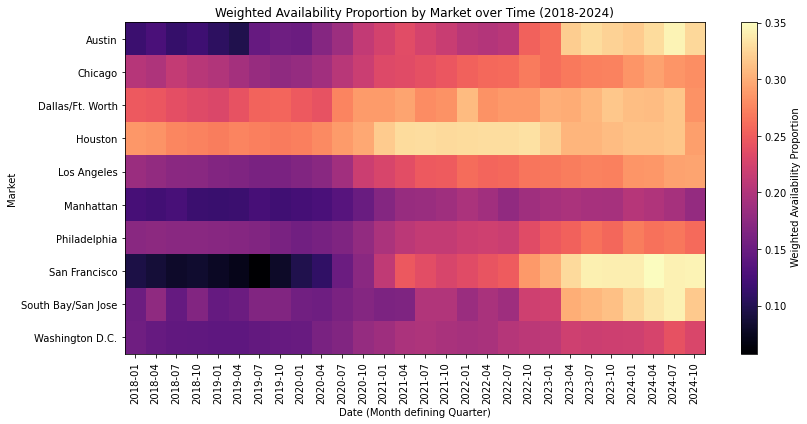

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


# Define the list of the 10 major markets (using our standardized naming)
major_markets = [
    'Austin', 'Chicago', 'Dallas/Ft. Worth', 'Houston', 'Los Angeles',
    'Manhattan', 'Philadelphia', 'San Francisco', 'South Bay/San Jose', 'Washington D.C.'
]

# Filter the grouped_pa DataFrame to include only these markets.
filtered_pa = grouped_pa[grouped_pa['market_std'].isin(major_markets)].copy()

# We want a matrix where each row is a market, each column is a date (quarter),
# and the cell values are the weighted availability proportion. This allows us to
# see trends over time for each market.
pivot_pa = filtered_pa.pivot(index='market_std', columns='date', values='availability_proportion_weighted')

# Sort the rows (markets) and columns (dates) to ensure they are in chronological order.
pivot_pa = pivot_pa.sort_index()
pivot_pa = pivot_pa.sort_index(axis=1)

# We use imshow to generate a heatmap from the pivot table.
fig, ax = plt.subplots(figsize=(12, 6))

# imshow expects a numeric matrix; the pivot table fits this need.
# The 'aspect' is set to 'auto' so the heatmap scales to the figure size.
# We use a colorblind-friendly colormap (e.g., 'viridis').
cax = ax.imshow(pivot_pa, aspect='auto', cmap='magma')

# Set Y-axis ticks and labels based on the market names (rows of the pivot table)
ax.set_yticks(np.arange(len(pivot_pa.index)))
ax.set_yticklabels(pivot_pa.index)

# Set X-axis ticks and labels using the dates (columns of the pivot table)
ax.set_xticks(np.arange(len(pivot_pa.columns)))
# Format the date labels as 'YYYY-MM' for clarity
date_labels = [pd.to_datetime(str(date)).strftime('%Y-%m') for date in pivot_pa.columns]
ax.set_xticklabels(date_labels, rotation=90)

# Label axes and add a title for context
ax.set_xlabel("Date (Month defining Quarter)")
ax.set_ylabel("Market")
ax.set_title("Weighted Availability Proportion by Market over Time (2018-2024)")

# Add a colorbar to show the mapping from color intensity to availability proportion
fig.colorbar(cax, ax=ax, label=" Weighted Availability Proportion")

plt.tight_layout()
plt.show()


/storage/icds/RISE/sw8/anaconda/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


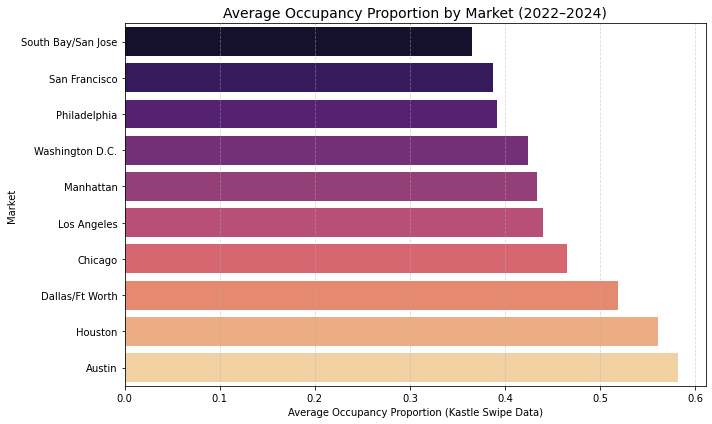

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the Kastle occupancy data
kastle = pd.read_csv('Major Market Occupancy Data-revised.csv')
kastle.columns = kastle.columns.str.strip()

# Filter to years 2022 to 2024
kastle_filtered = kastle[(kastle['year'] >= 2022) & (kastle['year'] <= 2024)].copy()

# Create 'date' column for merging or plotting if needed
def quarter_to_month(q): return {1: 1, 2: 4, 3: 7, 4: 10}.get(q, 1)
kastle_filtered['month'] = kastle_filtered['quarter'].apply(quarter_to_month)
kastle_filtered['date'] = pd.to_datetime(kastle_filtered['year'].astype(str) + '-' + kastle_filtered['month'].astype(str) + '-01')

# Average occupancy per market (across all quarters 2022–2024)
kastle_avg = kastle_filtered.groupby('market')['avg_occupancy_proportion'].mean().reset_index()
kastle_avg = kastle_avg.sort_values(by='avg_occupancy_proportion')

# Plot
plt.figure(figsize=(10,6))
sns.barplot(data=kastle_avg, x='avg_occupancy_proportion', y='market', palette='magma')
plt.title('Average Occupancy Proportion by Market (2022–2024)', fontsize=14)
plt.xlabel('Average Occupancy Proportion (Kastle Swipe Data)')
plt.ylabel('Market')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


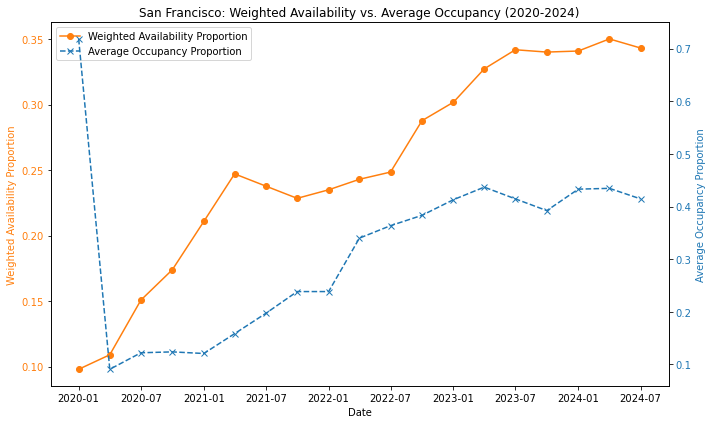

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

df_pa = pd.read_csv('Price and Availability Data.csv')
df_pa.columns = df_pa.columns.str.strip()

# Filter for Class A buildings only
df_pa = df_pa[df_pa['internal_class'] == 'A'].copy()

map_pa = {
    'Austin': 'Austin',
    'Chicago Suburbs': 'Chicago',
    'Downtown Chicago': 'Chicago',
    'Dallas-Ft. Worth': 'Dallas/Ft. Worth',   # noticed missing dash or space corrected
    'Houston': 'Houston',
    'Los Angeles': 'Los Angeles',
    'Manhattan': 'Manhattan',
    'Philadelphia': 'Philadelphia',
    'San Francisco': 'San Francisco',
    'South Bay': 'South Bay/San Jose',
    'Washington DC': 'Washington D.C.'         # noticed missing period corrected
}
df_pa['market_std'] = df_pa['market'].map(map_pa)

# Convert quarter info into numeric
df_pa['quarter'] = df_pa['quarter'].astype(str).str.replace('Q','', regex=False).astype(int)

# Helper function: Quarter to representative month
def quarter_to_month(q):
    return {1: 1, 2: 4, 3: 7, 4: 10}.get(q, 1)

df_pa['month'] = df_pa['quarter'].apply(quarter_to_month)

# Create a datetime column from year and month
df_pa['date'] = pd.to_datetime(df_pa['year'].astype(str) + '-' +
                               df_pa['month'].astype(str) + '-01')


grouped_pa = df_pa.groupby(['market_std', 'date']).agg({
    'available_space': 'sum',
    'RBA': 'sum'
}).reset_index()

# Compute Weighted Availability Proportion: available space divided by total RBA
grouped_pa['availability_proportion_weighted'] = grouped_pa['available_space'] / grouped_pa['RBA']

# Step 2: Filter Aggregated Data for San Francisco (Post-COVID: year >= 2020)

grouped_pa_sf = grouped_pa[(grouped_pa['market_std'] == 'San Francisco') & (grouped_pa['date'].dt.year >= 2020)].copy()
grouped_pa_sf = grouped_pa_sf.sort_values(by='date')

# Step 3: Process Major Market Occupancy (Kastle) Data
df_occ = pd.read_csv('Major Market Occupancy Data-revised.csv')
df_occ.columns = df_occ.columns.str.strip()

# Filter for years 2020 onward
df_occ = df_occ[df_occ['year'] >= 2020].copy()

# Clean the quarter column in occupancy data
df_occ['quarter'] = df_occ['quarter'].astype(str).str.replace('Q','', regex=False).astype(int)
df_occ['month'] = df_occ['quarter'].apply(quarter_to_month)

# Create a date column for occupancy data
df_occ['date'] = pd.to_datetime(df_occ['year'].astype(str) + '-' +
                                df_occ['month'].astype(str) + '-01')

# Filter for San Francisco from occupancy data (assuming 'market' column already uses 'San Francisco')
df_occ_sf = df_occ[df_occ['market'] == 'San Francisco'].copy()
df_occ_sf = df_occ_sf.sort_values(by='date')

#  Merge Aggregated Price & Availability with Occupancy Data for San Francisco
merged_sf = pd.merge(
    grouped_pa_sf[['date', 'availability_proportion_weighted']],
    df_occ_sf[['date', 'avg_occupancy_proportion']],
    on='date', how='inner'
)

# Step 5: Plot Dual-Axis Time Series for San Francisco
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot weighted availability on the left y-axis (orange)
p1 = ax1.plot(merged_sf['date'], merged_sf['availability_proportion_weighted'],
              label='Weighted Availability Proportion', color='tab:orange', marker='o', linestyle='-')
ax1.set_xlabel('Date')
ax1.set_ylabel('Weighted Availability Proportion', color='tab:orange')
ax1.tick_params(axis='y', labelcolor='tab:orange')

# Plot average occupancy on the right y-axis (blue)
ax2 = ax1.twinx()
p2 = ax2.plot(merged_sf['date'], merged_sf['avg_occupancy_proportion'],
              label='Average Occupancy Proportion', color='tab:blue', marker='x', linestyle='--')
ax2.set_ylabel('Average Occupancy Proportion', color='tab:blue')
ax2.tick_params(axis='y', labelcolor='tab:blue')

# Combine legends from both plots
lines = p1 + p2
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='upper left')

# Add chart title and layout adjustments
plt.title('San Francisco: Weighted Availability vs. Average Occupancy (2020-2024)')
plt.tight_layout()
plt.show()


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x14a992a24ee0>
Traceback (most recent call last):
  File "/storage/icds/RISE/sw8/anaconda/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/storage/icds/RISE/sw8/anaconda/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/storage/icds/RISE/sw8/anaconda/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/storage/icds/RISE/sw8/anaconda/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback functio

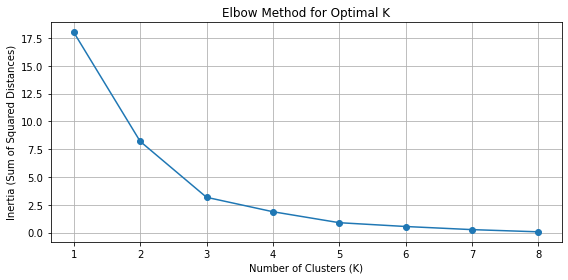

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score


df_occ = pd.read_csv("Major Market Occupancy Data-revised.csv")
df_occ.columns = df_occ.columns.str.strip()

# Filter for years 2022 to 2024 (post-COVID trends)
df_occ = df_occ[df_occ['year'] >= 2022].copy()

# Clean quarter data: remove 'Q' and convert to integer
df_occ['quarter'] = df_occ['quarter'].astype(str).str.replace('Q', '', regex=False).astype(int)
# Convert quarter to a representative month (Q1->Jan, Q2->Apr, etc.)
def quarter_to_month(q): 
    return {1: 1, 2: 4, 3: 7, 4: 10}.get(q, 1)
df_occ['month'] = df_occ['quarter'].apply(quarter_to_month)
# Create a date column for potential merging/plotting
df_occ['date'] = pd.to_datetime(df_occ['year'].astype(str) + '-' + df_occ['month'].astype(str) + '-01')

# Aggregate occupancy data by market: compute average occupancy proportion over the period
occ_summary = df_occ.groupby('market')['avg_occupancy_proportion'].mean().reset_index()

df_pa = pd.read_csv("Price and Availability Data.csv")
df_pa.columns = df_pa.columns.str.strip()

# Filter for Class A buildings only
df_pa = df_pa[df_pa['internal_class'] == 'A'].copy()

# --- Standardize market names --- 
map_pa = {
    'Austin': 'Austin',
    'Chicago Suburbs': 'Chicago',
    'Downtown Chicago': 'Chicago',
    'Dallas-Ft. Worth': 'Dallas/Ft. Worth',  # noticed missing dash or space corrected
    'Houston': 'Houston',
    'Los Angeles': 'Los Angeles',
    'Manhattan': 'Manhattan',
    'Philadelphia': 'Philadelphia',
    'San Francisco': 'San Francisco',
    'South Bay': 'South Bay/San Jose',
    'Washington DC': 'Washington D.C.'       # noticed missing period corrected
}
df_pa['market_std'] = df_pa['market'].map(map_pa)

# Convert quarter to numeric (remove 'Q' if needed)
df_pa['quarter'] = df_pa['quarter'].astype(str).str.replace('Q', '', regex=False).astype(int)
df_pa['month'] = df_pa['quarter'].apply(quarter_to_month)
df_pa['date'] = pd.to_datetime(df_pa['year'].astype(str) + '-' + df_pa['month'].astype(str) + '-01')

# Filter for years 2022 onward (post-COVID)
df_pa = df_pa[df_pa['year'] >= 2022].copy()

# Aggregate at the market level: weighted availability proportion is computed as:
# (Total available_space) / (Total RBA)
pa_summary = df_pa.groupby('market_std').apply(
    lambda x: x['available_space'].sum() / x['RBA'].sum()
).reset_index()
pa_summary.columns = ['market', 'availability_proportion_weighted']

# Now, 'merged' has one row per market, with two key features:
#   - avg_occupancy_proportion (from Kastle occupancy data)
#   - availability_proportion_weighted (from Price & Availability data)
merged = pd.merge(occ_summary, pa_summary, left_on='market', right_on='market', how='inner')

# ===============================

# Select features for clustering
X = merged[['avg_occupancy_proportion', 'availability_proportion_weighted']]

# Standardize the features to have zero mean and unit variance
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Determine the range for K. Since silhouette score requires K from 2 to n_samples - 1,
# we set max_k accordingly.
n_samples = len(X_scaled)
max_k = min(9, n_samples - 1)  # Use at most 9 or n_samples-1 clusters, whichever is lower

# (A) Elbow Method: Plot K vs. inertia
inertias = []
K_range = range(1, max_k + 1)
for k in K_range:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_scaled)
    inertias.append(km.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(K_range, inertias, marker='o', linestyle='-')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia (Sum of Squared Distances)")
plt.title("Elbow Method for Optimal K")
plt.xticks(K_range)
plt.grid(True)
plt.tight_layout()
plt.show()




In [7]:
# (B) Silhouette Scores: Compute silhouette score for K = 2 to max_k
print("Silhouette Scores:")
silhouette_scores = {}
for k in range(2, max_k + 1):
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    silhouette_scores[k] = score

    print(f"  K={k}: Silhouette Score = {score:.3f}")
    
    

Silhouette Scores:
  K=2: Silhouette Score = 0.491
  K=3: Silhouette Score = 0.515
  K=4: Silhouette Score = 0.418
  K=5: Silhouette Score = 0.472
  K=6: Silhouette Score = 0.348
  K=7: Silhouette Score = 0.252
  K=8: Silhouette Score = 0.148


In [8]:
# Based on the scores, we choose the optimal number of clusters.
optimal_k = 3  
print(f"Optimal number of clusters chosen: {optimal_k}")

# Fit the KMeans model using the optimal number of clusters
kmeans_opt = KMeans(n_clusters=optimal_k, random_state=42)
merged['cluster'] = kmeans_opt.fit_predict(X_scaled)

# Inverse transform the cluster centers to interpret them in the original scale
cluster_centers = scaler.inverse_transform(kmeans_opt.cluster_centers_)
cluster_centers_df = pd.DataFrame(cluster_centers, columns=['avg_occupancy_proportion', 'availability_proportion_weighted'])
print("Cluster Centers (Original Scale):")
print(cluster_centers_df)


Optimal number of clusters chosen: 3
Cluster Centers (Original Scale):
   avg_occupancy_proportion  availability_proportion_weighted
0                  0.409618                          0.275246
1                  0.571061                          0.301431
2                  0.428554                          0.203935


Cluster Centers (Original Scale):
   avg_occupancy_proportion  availability_proportion_weighted
0                  0.409618                          0.275246
1                  0.571061                          0.301431
2                  0.428554                          0.203935


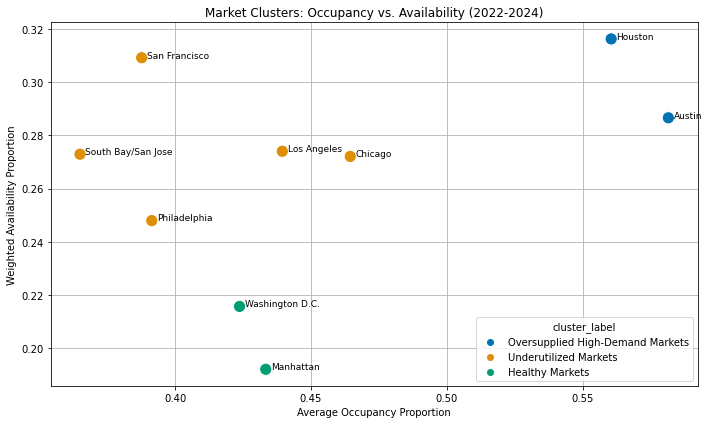

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

df_occ = pd.read_csv("Major Market Occupancy Data-revised.csv")
df_occ.columns = df_occ.columns.str.strip()

# Filter for years 2022 to 2024 (post-COVID trends)
df_occ = df_occ[df_occ['year'] >= 2022].copy()

# Clean quarter data: remove 'Q' and convert to integer
df_occ['quarter'] = df_occ['quarter'].astype(str).str.replace('Q', '', regex=False).astype(int)
# Convert quarter to representative month
def quarter_to_month(q): 
    return {1: 1, 2: 4, 3: 7, 4: 10}.get(q, 1)
df_occ['month'] = df_occ['quarter'].apply(quarter_to_month)
# Create a date column
df_occ['date'] = pd.to_datetime(df_occ['year'].astype(str) + '-' + df_occ['month'].astype(str) + '-01')

# Aggregate occupancy data by market: average occupancy proportion over the period
occ_summary = df_occ.groupby('market')['avg_occupancy_proportion'].mean().reset_index()

df_pa = pd.read_csv("Price and Availability Data.csv")
df_pa.columns = df_pa.columns.str.strip()

# Filter for Class A buildings
df_pa = df_pa[df_pa['internal_class'] == 'A'].copy()

# --- Standardize market names ---
map_pa = {
    'Austin': 'Austin',
    'Chicago Suburbs': 'Chicago',
    'Downtown Chicago': 'Chicago',
    'Dallas-Ft. Worth': 'Dallas/Ft. Worth',  # noticed missing dash or space corrected
    'Houston': 'Houston',
    'Los Angeles': 'Los Angeles',
    'Manhattan': 'Manhattan',
    'Philadelphia': 'Philadelphia',
    'San Francisco': 'San Francisco',
    'South Bay': 'South Bay/San Jose',
    'Washington DC': 'Washington D.C.'       # noticed missing period corrected
}
df_pa['market_std'] = df_pa['market'].map(map_pa)

# Convert quarter to numeric (remove 'Q' if needed)
df_pa['quarter'] = df_pa['quarter'].astype(str).str.replace('Q','', regex=False).astype(int)
df_pa['month'] = df_pa['quarter'].apply(quarter_to_month)
df_pa['date'] = pd.to_datetime(df_pa['year'].astype(str) + '-' + df_pa['month'].astype(str) + '-01')

# Filter for years 2022 onward (post-COVID)
df_pa = df_pa[df_pa['year'] >= 2022].copy()

# Aggregate at the market level: weighted availability proportion = total available_space / total RBA
pa_summary = df_pa.groupby('market_std').apply(
    lambda x: x['available_space'].sum() / x['RBA'].sum()
).reset_index()
pa_summary.columns = ['market', 'availability_proportion_weighted']


merged = pd.merge(occ_summary, pa_summary, left_on='market', right_on='market', how='inner')
# 'merged' now has:
# - avg_occupancy_proportion (from occupancy/Kastle data)
# - availability_proportion_weighted (from Price & Availability data)

X = merged[['avg_occupancy_proportion', 'availability_proportion_weighted']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

optimal_k = 3
kmeans_opt = KMeans(n_clusters=optimal_k, random_state=42)
merged['cluster'] = kmeans_opt.fit_predict(X_scaled)

# Inverse transform cluster centers to the original scale for interpretation
cluster_centers = scaler.inverse_transform(kmeans_opt.cluster_centers_)
cluster_centers_df = pd.DataFrame(cluster_centers, columns=['avg_occupancy_proportion', 'availability_proportion_weighted'])
print("Cluster Centers (Original Scale):")
print(cluster_centers_df)

cluster_label_map = {0: "Underutilized Markets", 1: "Oversupplied High-Demand Markets", 2: "Healthy Markets"}
merged['cluster_label'] = merged['cluster'].map(cluster_label_map)

plt.figure(figsize=(10, 6))
# Use a colorblind-friendly palette
cb_palette = sns.color_palette("colorblind", optimal_k)
sns.scatterplot(data=merged, x='avg_occupancy_proportion', y='availability_proportion_weighted',
                hue='cluster_label', palette=cb_palette, s=150)

# Annotate each point with market name for clarity.
for i in range(len(merged)):
    plt.text(merged['avg_occupancy_proportion'].iloc[i] + 0.002, 
             merged['availability_proportion_weighted'].iloc[i], 
             merged['market'].iloc[i], fontsize=9)

plt.title('Market Clusters: Occupancy vs. Availability (2022-2024)')
plt.xlabel('Average Occupancy Proportion')
plt.ylabel('Weighted Availability Proportion')
plt.grid(True)
plt.tight_layout()
plt.show()


In [46]:
import time
import csv
import json
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

# -------------------------------
# DATA PREPARATION: Load, filter, and sample buildings.
# -------------------------------
df_leases = pd.read_csv("Leases.csv")
df_leases.columns = df_leases.columns.str.strip()

market_map = {
    'Austin': 'Austin',
    'Chicago': 'Chicago',
    'Chicago Suburbs': 'Chicago',
    'Dallas/Ft Worth': 'Dallas/Ft. Worth',
    'Houston': 'Houston',
    'Los Angeles': 'Los Angeles',
    'Philadelphia': 'Philadelphia',
    'San Francisco': 'San Francisco',
    'South Bay/San Jose': 'South Bay/San Jose',
}
df_leases = df_leases[df_leases['market'].isin(market_map.keys())]
df_leases['market_std'] = df_leases['market'].map(market_map)
df_leases['leasedSF'] = pd.to_numeric(df_leases['leasedSF'], errors='coerce')

# Filter for Class A buildings only.
df_classA = df_leases[df_leases['internal_class'] == 'A'].copy()
leased_sf_by_building = df_classA.groupby('costarID')['leasedSF'].sum().reset_index()
leased_sf_filtered = leased_sf_by_building[leased_sf_by_building['leasedSF'] > 10000]

# Get building-level information.
if 'building_name' in df_classA.columns:
    building_info = df_classA[['costarID', 'address', 'zip', 'market_std', 'CBD_suburban', 'building_name']].drop_duplicates()
    building_info = building_info[building_info['building_name'].notna() & (building_info['building_name'].str.strip() != "")]
else:
    building_info = df_classA[['costarID', 'address', 'zip', 'market_std', 'CBD_suburban']].drop_duplicates()

filtered_buildings = pd.merge(leased_sf_filtered, building_info, on='costarID', how='left')
# Clean up ZIP: remove trailing ".0"
filtered_buildings["zip"] = filtered_buildings["zip"].astype(str).str.replace(r'\.0$', '', regex=True)

print("CBD/Suburban Distribution:")
print(filtered_buildings['CBD_suburban'].value_counts(normalize=True))

# Define target sample size and sample proportionally.
target_total = 1900
suburban_frac = 0.608
cbd_n = target_total - int(target_total * suburban_frac)
suburban_n = int(target_total * suburban_frac)

cbd_subset = filtered_buildings[filtered_buildings['CBD_suburban'] == 'CBD']
suburban_subset = filtered_buildings[filtered_buildings['CBD_suburban'] == 'Suburban']

cbd_sample = cbd_subset.sample(n=min(cbd_n, len(cbd_subset)), random_state=42)
suburban_sample = suburban_subset.sample(n=min(suburban_n, len(suburban_subset)), random_state=42)

final_buildings = pd.concat([cbd_sample, suburban_sample]).reset_index(drop=True)
# Ensure costarID fields are strings for proper merging.
final_buildings['costarID'] = final_buildings['costarID'].astype(str)

print(f"\n Final sample size: {len(final_buildings)} rows")
pd.set_option('display.max_rows', 10)
display(final_buildings.head())
# -------------------------------
# LOAD THE REGRID SCRAPED DATA
# -------------------------------
# The file "property_data_for_all_buildings.csv" contains the scraped panel-body fields 
# (e.g. "Parcel ID", "Net Rent Area", etc.) for each building.
property_data = pd.read_csv("property_data_for_all_buildings.csv")
# Drop any "zip" from property_data to avoid conflict; use the zip from building info.
if 'zip' in property_data.columns:
    property_data = property_data.drop(columns=['zip'])
property_data['costarID'] = property_data['costarID'].astype(str)

# -------------------------------
# MERGE INTERNAL DATA WITH REGRID SCRAPED DATA
# -------------------------------
merged_data = pd.merge(final_buildings, property_data, on="costarID", how="left")

# -------------------------------
# STEP 2: Data Cleaning and Formatting
# -------------------------------
# Clean the ZIP code formatting (remove trailing ".0" if present).
merged_data["zip"] = merged_data["zip"].astype(str).str.replace(r'\.0$', '', regex=True)
# Convert internal leasedSF to numeric.
merged_data["leasedSF"] = pd.to_numeric(merged_data["leasedSF"], errors='coerce')
# Convert Net Rent Area from scraped data: remove commas (if any) and convert to numeric.
if "Net Rent Area" in merged_data.columns:
    merged_data["Net Rent Area"] = merged_data["Net Rent Area"].replace({',': ''}, regex=True)
    merged_data["Net Rent Area"] = pd.to_numeric(merged_data["Net Rent Area"], errors='coerce')
else:
    print("Warning: 'Net Rent Area' column is missing from property_data.")

# -------------------------------
# STEP 3: Compute Lease-to-RBA Ratio
# -------------------------------
merged_data["lease_to_RBA_ratio"] = merged_data["leasedSF"] / merged_data["Net Rent Area"]

# -------------------------------
# STEP 4: Classify Building Utilization
# -------------------------------
def classify_utilization(ratio):
    if np.isnan(ratio):
        return "NA"
    elif ratio >= 0.8:
        return "Fully Utilized"      # High lease-to-RBA ratio indicates most available space is leased.
    elif ratio < 0.5:
        return "Underutilized"        # Low ratio indicates limited leased space.
    else:
        return "Overpriced"           # Intermediate ratio—potential overpricing relative to usage.

merged_data["Utilization Classification"] = merged_data["lease_to_RBA_ratio"].apply(classify_utilization)

# -------------------------------
# STEP 5: Save the Final Merged Dataset
# -------------------------------
final_output_filename = "merged_property_data.csv"
merged_data.to_csv(final_output_filename, index=False)
print(f"Final merged data with classifications saved to {final_output_filename}")



CBD/Suburban Distribution:
Suburban    0.682279
CBD         0.317721
Name: CBD_suburban, dtype: float64

 Final sample size: 1813 rows


,costarID,leasedSF,address,zip,market_std,CBD_suburban,building_name
0,9841780,35536.0,401 Franklin St,77201,Houston,CBD,POST Houston
1,300256,676202.0,1717 Arch St,19103,Philadelphia,CBD,Three Logan Square
2,258902,68963.0,750 San Vicente Blvd,90069,Los Angeles,CBD,Pacific Design Center Red Building West
3,144368,534473.0,515 N State St,60654,Chicago,CBD,FiveOneFive
4,320497,75865.0,22 4th St,94103,San Francisco,CBD,Pacific Place


Final merged data with classifications saved to merged_property_data.csv


In [12]:
import sys
!{sys.executable} -m pip install selenium


Defaulting to user installation because normal site-packages is not writeable


In [13]:
from selenium import webdriver
print("✅ Selenium is working!")


✅ Selenium is working!


In [41]:
!pip install folium 

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 110 kB 4.7 MB/s eta 0:00:01
     |████████████████████████████████| 88 kB 2.7 MB/s  eta 0:00:01
     |████████████████████████████████| 134 kB 27.7 MB/s eta 0:00:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
anaconda-project 0.10.1 requires ruamel-yaml, which is not installed.
cookiecutter 1.7.2 requires Jinja2<3.0.0, but you have jinja2 3.1.6 which is incompatible.
cookiecutter 1.7.2 requires MarkupSafe<2.0.0, but you have markupsafe 3.0.2 which is incompatible.


KeyError: 'lat'

In [37]:
!pip install pandas googlemaps gmplot


Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 164 kB 8.7 MB/s eta 0:00:01
  Created wheel for googlemaps: filename=googlemaps-4.10.0-py3-none-any.whl size=40716 sha256=d9d05658ff32c948774484cb2acf529dbeec0cbbc673413fa27169b3e5bd837c
  Stored in directory: /storage/home/rzb5742/.cache/pip/wheels/d9/5f/46/54a2bdb4bcb07d3faba4463d2884865705914cc72a7b8bb5f0
Successfully built googlemaps


In [53]:
!pip install geopy 

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 125 kB 5.8 MB/s eta 0:00:01
     |████████████████████████████████| 40 kB 2.0 MB/s  eta 0:00:01


In [55]:
import pandas as pd
import folium
import json
import time
from geopy.geocoders import Nominatim

# -------------------------------
# STEP 1: Load the Dataset
# -------------------------------
df = pd.read_csv("cleaned_utilization_analysis.csv")

# Define the market classification mapping.
market_class = {
    'Houston': 'Oversupplied High-Demand',
    'Austin': 'Oversupplied High-Demand',
    'San Francisco': 'Underutilized',
    'South Bay': 'Underutilized',
    'Los Angeles': 'Underutilized',
    'Chicago': 'Underutilized',
    'Philadelphia': 'Underutilized'
}

# Map the classification to each record (using the 'market_std' column)
df['Market Classification'] = df['market_std'].map(market_class)

# -------------------------------
# STEP 2: Generate GeoJSON with Market Boundaries
# -------------------------------
# We'll generate boundaries for the markets in our mapping.
markets_to_generate = list(market_class.keys())

# Initialize the Nominatim geocoder.
geolocator = Nominatim(user_agent="market_boundaries_generator")
features = []

for market in markets_to_generate:
    try:
        location = geolocator.geocode(market, exactly_one=True)
        if location and "boundingbox" in location.raw:
            bbox = location.raw["boundingbox"]  # Format: [south, north, west, east]
            south, north = float(bbox[0]), float(bbox[1])
            west, east = float(bbox[2]), float(bbox[3])
            # Create a rectangle polygon (bounding box)
            polygon = [
                [south, west],
                [south, east],
                [north, east],
                [north, west],
                [south, west]  # Close the polygon
            ]
            features.append({
                "type": "Feature",
                "properties": {
                    "market_std": market,  # Ensure this matches our DataFrame's key
                    "market": market
                },
                "geometry": {
                    "type": "Polygon",
                    "coordinates": [polygon]
                }
            })
            print(f"✓ Added {market}")
        else:
            print(f"✗ Bounding box not found for: {market}")
    except Exception as e:
        print(f"Error geocoding {market}: {e}")
    time.sleep(1)  # Pause to respect Nominatim's rate limits

# Combine features into a GeoJSON FeatureCollection.
geojson_data = {
    "type": "FeatureCollection",
    "features": features
}

# Save the generated GeoJSON to a file.
with open("market_boundaries.geojson", "w") as f:
    json.dump(geojson_data, f)
print("GeoJSON file 'market_boundaries.geojson' created.")

# -------------------------------
# STEP 3: Load the GeoJSON with Market Boundaries
# -------------------------------
with open("market_boundaries.geojson") as f:
    geo_data = json.load(f)


    color_mapping = {
    'Oversupplied High-Demand': '#FF0000',  # Red
    'Underutilized': '#FFA500',             # Orange
    'Healthy': '#008000',                   # Green (if applicable)
}


# Center the map over the U.S.
m = folium.Map(location=[39.8283, -98.5795], zoom_start=4)

def style_function(feature):
    market_name = feature['properties'].get('market_std')
    # Look up the classification using our mapping.
    classification = market_class.get(market_name, "Unknown")
    return {
        'fillOpacity': 0.7,
        'weight': 0.5,
        'color': 'black',
        'fillColor': color_mapping.get(classification, 'gray')
    }

# Add a GeoJson layer to display market boundaries with our styling.
folium.GeoJson(
    geo_data,
    name="Market Boundaries",
    style_function=style_function,
    tooltip=folium.features.GeoJsonTooltip(fields=['market'], aliases=['Market:'])
).add_to(m)

# -------------------------------
# STEP 6: Save or Display the Map
# -------------------------------
m.save("market_utilization_choropleth.html")
print("Choropleth map saved as 'market_utilization_choropleth.html'")


✓ Added Houston
✓ Added Austin
✓ Added San Francisco
✓ Added South Bay
✓ Added Los Angeles
✓ Added Chicago
✓ Added Philadelphia
GeoJSON file 'market_boundaries.geojson' created.
Choropleth map saved as 'market_utilization_choropleth.html'


Lat: 30.2743023, Lng: -97.7344636


SessionNotCreatedException: Message: session not created: probably user data directory is already in use, please specify a unique value for --user-data-dir argument, or don't use --user-data-dir
Stacktrace:
#0 0x55ad725a9d0a <unknown>
#1 0x55ad7205a5f0 <unknown>
#2 0x55ad720940db <unknown>
#3 0x55ad7208fe2f <unknown>
#4 0x55ad720dff9e <unknown>
#5 0x55ad720df4c6 <unknown>
#6 0x55ad720d1433 <unknown>
#7 0x55ad7209dea3 <unknown>
#8 0x55ad7209eb01 <unknown>
#9 0x55ad7256eb5b <unknown>
#10 0x55ad72572a41 <unknown>
#11 0x55ad72555c52 <unknown>
#12 0x55ad725735b4 <unknown>
#13 0x55ad72539f0f <unknown>
#14 0x55ad72597db8 <unknown>
#15 0x55ad72597f96 <unknown>
#16 0x55ad725a8b56 <unknown>
#17 0x1475bf4821ca start_thread
